# HEALTH INSURANCE DATASET

### COMPARING REGRESSION MODELS

* Some regression models will be trained with the same data.

* Scores will be taken according to the training made on pure data. (therefore no data engineering will be done)

* By comparing train and test scores at all stages, overfitting and underfitting conditions will be checked.

* R2, root mean squared error from grid search cross validation and root mean squared error of test data will be compared to select the best model.

* Predictions will be made on the health_test dataset with the selected regression model

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV, ElasticNet, ElasticNetCV
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from xgboost import XGBRegressor

from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Libraries for Style
from colorama import Fore
from colorama import Style

import warnings
warnings.filterwarnings('ignore')

plt.rcParams["figure.figsize"] = (10,6)
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 200)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [2]:
df = pd.read_csv("health_train.csv")
df.head()

,age,sex,bmi,smoker,region,children,charges
0,21.000,male,25.745,no,northeast,2,3279.869
1,36.977,female,25.744,yes,southeast,3,21454.494
2,18.000,male,30.030,no,southeast,1,1720.354
3,37.000,male,30.677,no,northeast,3,6801.438
4,58.000,male,32.010,no,southeast,1,11946.626


# Exploratory Data Analysis (EDA)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       2500 non-null   float64
 1   sex       2500 non-null   object 
 2   bmi       2500 non-null   float64
 3   smoker    2500 non-null   object 
 4   region    2500 non-null   object 
 5   children  2500 non-null   int64  
 6   charges   2500 non-null   float64
dtypes: float64(3), int64(1), object(3)
memory usage: 136.8+ KB


In [4]:
df.shape, df.size

((2500, 7), 17500)

In [5]:
df.isnull().sum().sum()

0

In [6]:
df.duplicated().sum()

0

In [7]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,2500.000,39.003,12.265,18.000,28.846,39.350,48.689,64.000
bmi,2500.000,30.575,5.390,15.960,26.718,30.200,34.046,53.130
children,2500.000,2.488,1.707,0.000,1.000,2.000,4.000,5.000
charges,2500.000,12679.312,10593.270,1121.874,5612.781,9455.047,14440.628,63770.428


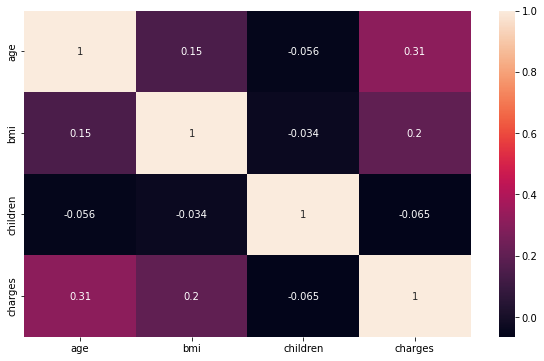

In [8]:
sns.heatmap(df.corr(), annot = True);

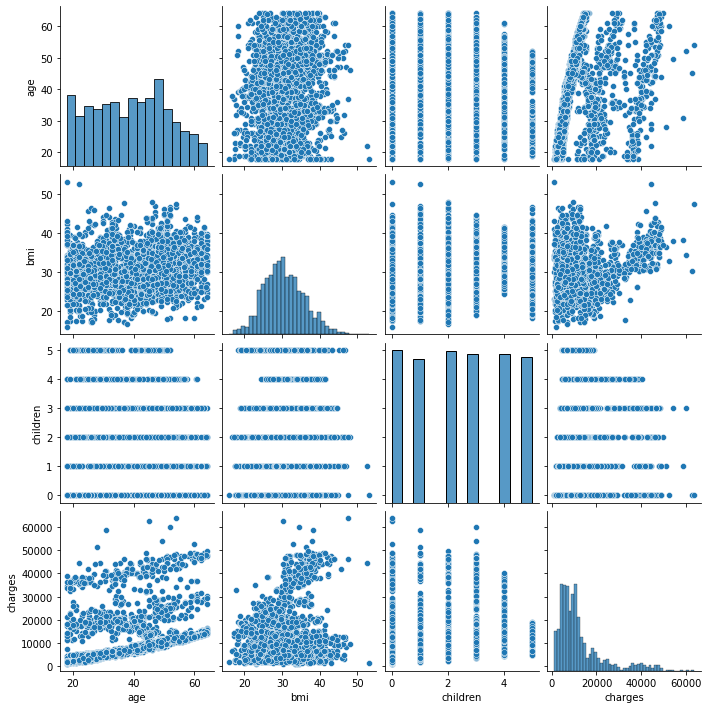

In [9]:
sns.pairplot(df);

***object type columns***

In [10]:
df.select_dtypes('object').nunique()

sex       2
smoker    2
region    4
dtype: int64

In [11]:
df.sex.value_counts()

male      1387
female    1113
Name: sex, dtype: int64

In [12]:
df.smoker.value_counts()

no     2124
yes     376
Name: smoker, dtype: int64

In [13]:
df.region.value_counts()

southeast    699
northwest    613
northeast    606
southwest    582
Name: region, dtype: int64

***numeric columns***

***target label***

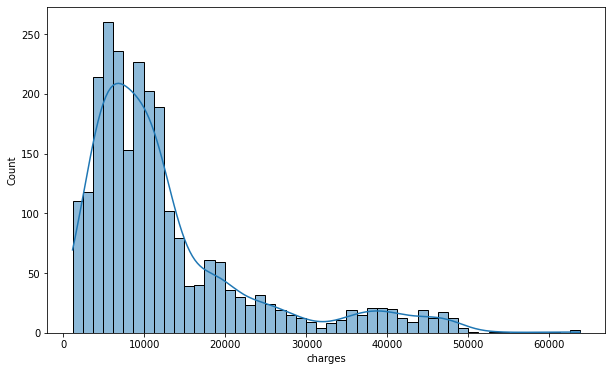

In [14]:
sns.histplot(df.charges, bins=50, kde=True);

***age***

In [15]:
# I will convert age values to integer type
df['age'] = df['age'].round().astype(int)

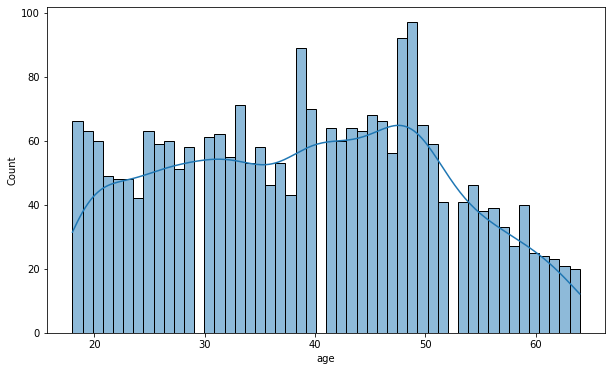

In [16]:
sns.histplot(df.age, bins=50, kde=True);

***bmi***

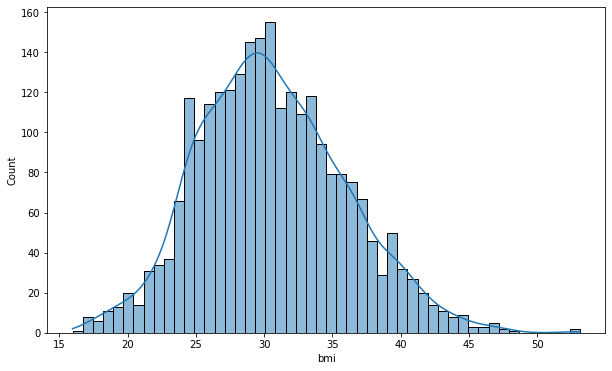

In [17]:
sns.histplot(df.bmi, bins=50, kde=True);

***children***

In [18]:
df.children.value_counts()

0    427
2    426
4    418
3    416
5    409
1    404
Name: children, dtype: int64

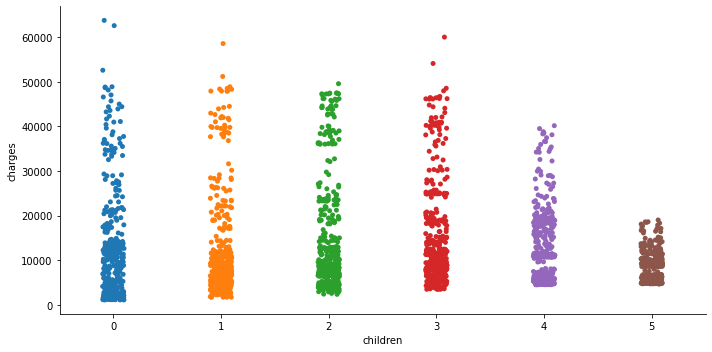

In [19]:
sns.catplot(x="children", y="charges", data=df, height=5, aspect=2)

***checking outliers and examining the target label according to object type columns***

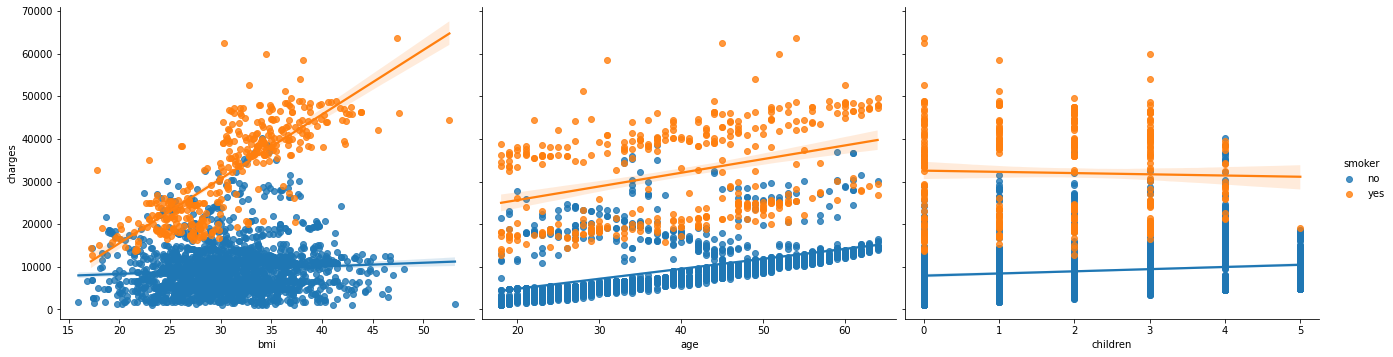

In [20]:
sns.pairplot(df, 
             y_vars=['charges'], hue='smoker',
             x_vars=['bmi', 'age', 'children'],
             # plot_kws={'color':'purple', 'line_kws': {'color':'black', 'lw': 3}}, 
             kind='reg', height=5, aspect=1.25);

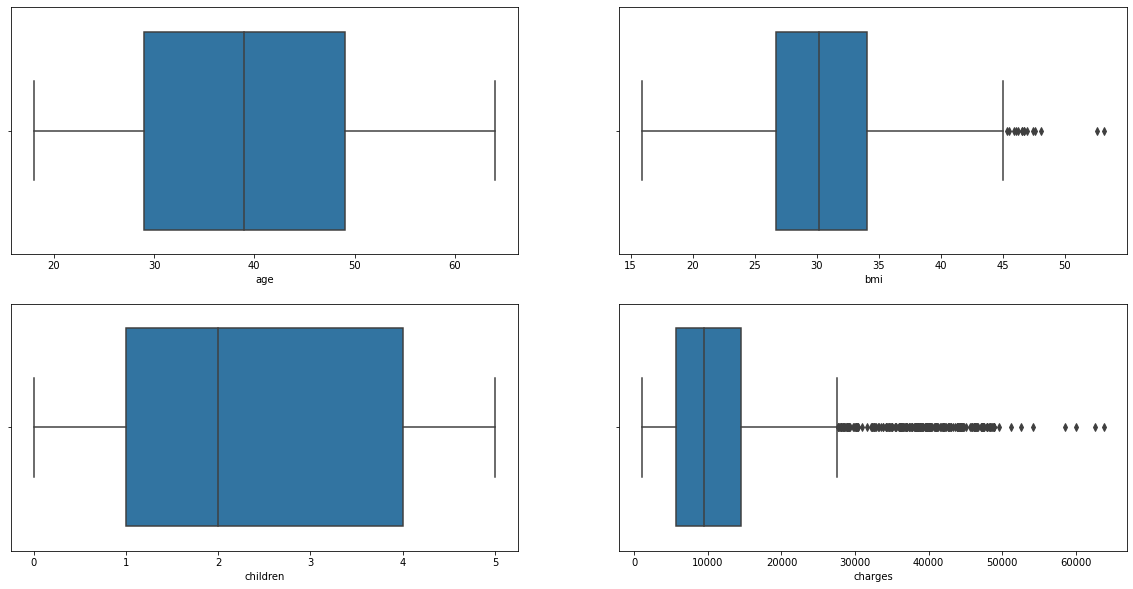

In [21]:
# columns = ['age', 'bmi', 'children', 'charges']
index = 0
plt.figure(figsize=(20,10))
for col in df.select_dtypes(['int', 'float64']):    
    index += 1
    plt.subplot(2,2,index)
    sns.boxplot(data=df, x=col)

<AxesSubplot:xlabel='smoker', ylabel='charges'>

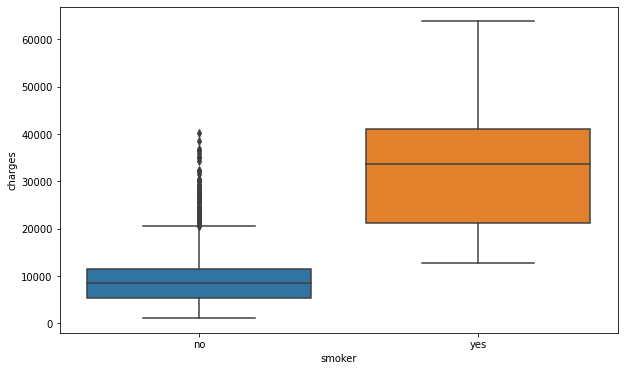

In [22]:
sns.boxplot(x='smoker', y='charges', data=df)

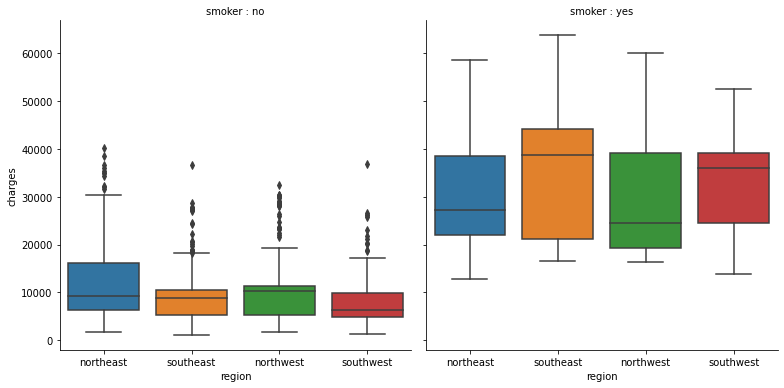

In [23]:
g = sns.catplot(x='region', y='charges', 
                data=df,
                col='smoker',
                kind='box',
                height=5.5
               )
g.set_titles(col_template="smoker : {col_name}");

In [24]:
df.groupby('smoker').describe().T

smoker                no       yes
age      count  2124.000   376.000
         mean     38.839    39.955
         std      12.158    12.819
         min      18.000    18.000
         25%      29.000    29.000
         50%      39.000    41.000
         75%      48.250    50.000
         max      64.000    64.000
bmi      count  2124.000   376.000
         mean     30.511    30.943
         std       5.288     5.926
         min      15.960    17.195
         25%      26.783    26.399
         50%      30.108    30.800
         75%      33.817    34.960
         max      53.130    52.580
children count  2124.000   376.000
         mean      2.613     1.782
         std       1.748     1.244
         min       0.000     0.000
         25%       1.000     1.000
         50%       3.000     2.000
         75%       4.000     3.000
         max       5.000     5.000
charges  count  2124.000   376.000
         mean   9250.795 32046.783
         std    5652.805 11146.085
         min    1121.874 12829.455
         25%    5237.098 21222.857
         50%    8548.635 33741.489
         75%   11388.920 41049.956
         max   40160.789 63770.428

In [25]:
df[df.smoker=='yes'].corr()

,age,bmi,children,charges
age,1.000,0.112,0.078,0.368
bmi,0.112,1.000,0.019,0.803
children,0.078,0.019,1.000,-0.032
charges,0.368,0.803,-0.032,1.000


In [26]:
df[df.smoker=='no'].corr()

,age,bmi,children,charges
age,1.000,0.153,-0.068,0.503
bmi,0.153,1.000,-0.037,0.081
children,-0.068,-0.037,1.000,0.158
charges,0.503,0.081,0.158,1.000


In [27]:
# OUTLIERS

iqr_factor = [2, 3]
list1, list2 = [], []

for factor in iqr_factor:
    count = 0
    print(f'Outliers for {factor} IQR :')
    print('-------------------------------------')
    for col in df.select_dtypes(['int', 'float64']).columns:
    
        IQR = df[col].quantile(0.75) - df[col].quantile(0.25)
        lower_lim = df[col].quantile(0.25) - factor*IQR
        upper_lim = df[col].quantile(0.75) + factor*IQR
    
        cond = df[(df[col] < lower_lim) | (df[col] > upper_lim)].shape[0]
        
        if cond > 0 and factor == 2:
            list1.append(df[(df[col] < lower_lim) | (df[col] > upper_lim)].index.tolist())
        if cond > 0 and factor == 3:
            list2.append(df[(df[col] < lower_lim) | (df[col] > upper_lim)].index.tolist())
        
        if cond > 0: print(f'{col:<30} : ', cond); count += cond
    print(f'\n{Fore.RED}TOTAL OUTLIERS FOR {factor} IQR : {count}{Style.RESET_ALL}')
    print('')

Outliers for 2 IQR :
-------------------------------------
bmi                            :  2
charges                        :  210

TOTAL OUTLIERS FOR 2 IQR : 212

Outliers for 3 IQR :
-------------------------------------
charges                        :  98

TOTAL OUTLIERS FOR 3 IQR : 98



In [ ]:
# I will keep outliers for now because of the 'smoker' feature effect

# df = df.drop(index=sum(liste1, [])).reset_index(drop=True)  ===> DROPPING OUTLIERS WITH 2 IQR
# df = df.drop(index=sum(liste2, [])).reset_index(drop=True)  ===> DROPPING OUTLIERS WITH 3 IQR

***

# Data Preprocessing

In [28]:
X = pd.get_dummies(df.drop('charges', axis=1), drop_first=True)
y = df['charges']

In [29]:
X.head()

,age,bmi,children,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
0,21,25.745,2,1,0,0,0,0
1,37,25.744,3,0,1,0,1,0
2,18,30.030,1,1,0,0,1,0
3,37,30.677,3,1,0,0,0,0
4,58,32.010,1,1,0,0,1,0


In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [31]:
print("Train features shape : ", X_train.shape)
print("Train target shape   : ", y_train.shape)
print("Test features shape  : ", X_test.shape)
print("Test target shape    : ", y_test.shape)

Train features shape :  (2000, 8)
Train target shape   :  (2000,)
Test features shape  :  (500, 8)
Test target shape    :  (500,)


In [32]:
def train_val(model, X_train, y_train, X_test, y_test):
    
    y_pred = model.predict(X_test)
    y_train_pred = model.predict(X_train)
    
    scores = {"train": {"R2" : r2_score(y_train, y_train_pred),
    "mae" : mean_absolute_error(y_train, y_train_pred),
    "mse" : mean_squared_error(y_train, y_train_pred),                          
    "rmse" : np.sqrt(mean_squared_error(y_train, y_train_pred))},
    
    "test": {"R2" : r2_score(y_test, y_pred),
    "mae" : mean_absolute_error(y_test, y_pred),
    "mse" : mean_squared_error(y_test, y_pred),
    "rmse" : np.sqrt(mean_squared_error(y_test, y_pred))}}
    
    return pd.DataFrame(scores)

***

# Model Implementing

<div class="alert alert-block alert-danger">
    
<b>Linear Regression</b>
    
</div>

In [33]:
operations_linear = [("scaler", MinMaxScaler()), ("linear", LinearRegression())]
pipe_linear_model = Pipeline(steps=operations_linear)
pipe_linear_model.fit(X_train,y_train)

Pipeline(steps=[('scaler', MinMaxScaler()), ('linear', LinearRegression())])

In [34]:
pipe_linear_model.get_params()

{'memory': None,
 'steps': [('scaler', MinMaxScaler()), ('linear', LinearRegression())],
 'verbose': False,
 'scaler': MinMaxScaler(),
 'linear': LinearRegression(),
 'scaler__clip': False,
 'scaler__copy': True,
 'scaler__feature_range': (0, 1),
 'linear__copy_X': True,
 'linear__fit_intercept': True,
 'linear__n_jobs': None,
 'linear__normalize': False,
 'linear__positive': False}

In [35]:
train_val(pipe_linear_model, X_train, y_train, X_test, y_test)

,train,test
R2,0.713,0.712
mae,3854.333,3632.571
mse,32789931.869,30012518.364
rmse,5726.249,5478.368


In [36]:
# CROSS VALIDATION

operations = [("scaler", MinMaxScaler()), ("linear", LinearRegression())]
model = Pipeline(steps=operations)

scores = cross_validate(model, X_train, y_train, scoring=['r2','neg_mean_absolute_error','neg_mean_squared_error',
                                                            'neg_root_mean_squared_error'], cv=10)
scores = pd.DataFrame(scores, index=range(1,11))
scores.iloc[:, 2:].mean()

test_r2                                    0.704
test_neg_mean_absolute_error           -3877.843
test_neg_mean_squared_error        -33141354.627
test_neg_root_mean_squared_error       -5746.525
dtype: float64

In [37]:
y_pred = pipe_linear_model.predict(X_test)
linear_R2 = r2_score(y_test, y_pred)
linear_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
linear_cvscore = -scores.iloc[:, 2:].mean()[3]

***residuals***

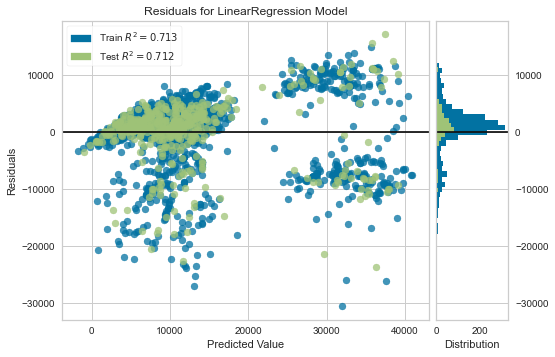

In [38]:
from yellowbrick.regressor import ResidualsPlot

operations = [("scaler", MinMaxScaler()), ("linear", LinearRegression())]
model = Pipeline(steps=operations)

visualizer = ResidualsPlot(model)

visualizer.fit(X_train, y_train) 
visualizer.score(X_test, y_test)  
visualizer.show(); 

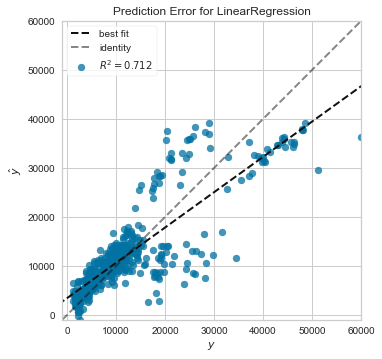

In [39]:
from yellowbrick.regressor import PredictionError
# visualizer = RadViz(size=(500, 500))
visualizer = PredictionError(model)

visualizer.fit(X_train, y_train) 
visualizer.score(X_test, y_test)  
visualizer.show();

<div class="alert alert-block alert-danger">
    
<b>Ridge Regression</b>
    
</div>

In [40]:
operations_ridge = [("scaler", MinMaxScaler()), ("ridge", Ridge(random_state=101))]
pipe_ridge_model = Pipeline(steps=operations_ridge)
pipe_ridge_model.fit(X_train,y_train)

Pipeline(steps=[('scaler', MinMaxScaler()), ('ridge', Ridge(random_state=101))])

In [41]:
pipe_ridge_model.get_params()

{'memory': None,
 'steps': [('scaler', MinMaxScaler()), ('ridge', Ridge(random_state=101))],
 'verbose': False,
 'scaler': MinMaxScaler(),
 'ridge': Ridge(random_state=101),
 'scaler__clip': False,
 'scaler__copy': True,
 'scaler__feature_range': (0, 1),
 'ridge__alpha': 1.0,
 'ridge__copy_X': True,
 'ridge__fit_intercept': True,
 'ridge__max_iter': None,
 'ridge__normalize': False,
 'ridge__random_state': 101,
 'ridge__solver': 'auto',
 'ridge__tol': 0.001}

In [42]:
train_val(pipe_ridge_model, X_train, y_train, X_test, y_test)

,train,test
R2,0.713,0.712
mae,3854.741,3636.019
mse,32792558.844,30015532.776
rmse,5726.479,5478.643


In [43]:
# CROSS VALIDATE

operations_ridge = [("scaler", MinMaxScaler()), ("ridge", Ridge(random_state=101))]
pipe_ridge_model = Pipeline(steps=operations_ridge)

scores = cross_validate(pipe_ridge_model, X_train, y_train, scoring=['r2','neg_mean_absolute_error','neg_mean_squared_error',
                                                            'neg_root_mean_squared_error'], cv=10)
scores = pd.DataFrame(scores, index=range(1,11))
scores.iloc[:, 2:].mean()

test_r2                                    0.704
test_neg_mean_absolute_error           -3877.807
test_neg_mean_squared_error        -33141883.700
test_neg_root_mean_squared_error       -5746.485
dtype: float64

***grid search***

In [44]:
# RIDGE GRID SEARCH

operations_ridge = [("scaler", MinMaxScaler()), ("ridge", Ridge(random_state=101))]
pipe_ridge_model = Pipeline(steps=operations_ridge)

param_grid = {'ridge__alpha':np.linspace(0.01, 1, 100)}

ridge_grid_model = GridSearchCV(estimator=pipe_ridge_model, param_grid=param_grid, scoring='neg_root_mean_squared_error',
                    cv=10, verbose=1, n_jobs = -1).fit(X_train, y_train)

print('\n', ridge_grid_model.best_params_)
print('\n', ridge_grid_model.best_score_)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits

 {'ridge__alpha': 0.5700000000000001}

 -5746.433813375749


In [45]:
ridge_scores = train_val(ridge_grid_model, X_train, y_train, X_test, y_test)
ridge_scores

,train,test
R2,0.713,0.712
mae,3854.430,3634.445
mse,32790794.747,30013557.019
rmse,5726.325,5478.463


In [46]:
y_pred = ridge_grid_model.predict(X_test)
ridge_R2 = r2_score(y_test, y_pred)
ridge_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
ridge_cvscore = -ridge_grid_model.best_score_

***feature importance***

In [47]:
ridge_grid_model.best_estimator_.named_steps["ridge"]

Ridge(alpha=0.5700000000000001, random_state=101)

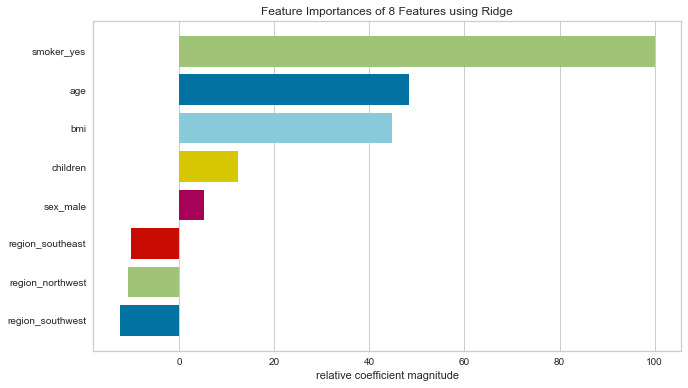

<AxesSubplot:title={'center':'Feature Importances of 8 Features using Ridge'}, xlabel='relative coefficient magnitude'>

In [49]:
from yellowbrick.model_selection import FeatureImportances
from yellowbrick.features import RadViz

viz = FeatureImportances(ridge_grid_model.best_estimator_.named_steps["ridge"])
visualizer = RadViz(size=(700, 400))
viz.fit(X_train, y_train)
viz.show()

***residuals***

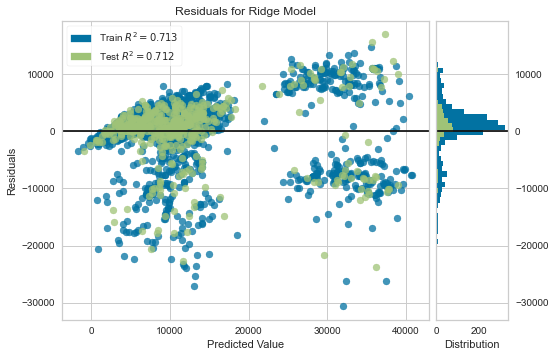

In [50]:
from yellowbrick.regressor import ResidualsPlot

operations = [("scaler", MinMaxScaler()), ("ridge", Ridge(alpha=0.57, random_state=101))]
model = Pipeline(steps=operations)
visualizer = ResidualsPlot(model)

visualizer.fit(X_train, y_train) 
visualizer.score(X_test, y_test)  
visualizer.show(); 

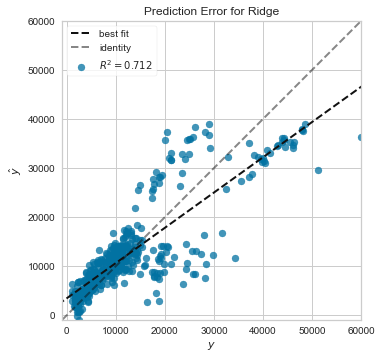

In [51]:
from yellowbrick.regressor import PredictionError
# visualizer = RadViz(size=(500, 500))
visualizer = PredictionError(model)

visualizer.fit(X_train, y_train) 
visualizer.score(X_test, y_test)  
visualizer.show();

<div class="alert alert-block alert-danger">
    
<b>Lasso Regression</b>
    
</div>

In [52]:
operations_lasso = [("scaler", MinMaxScaler()), ("lasso", Lasso(random_state=101))]
pipe_lasso_model = Pipeline(steps=operations_lasso)
pipe_lasso_model.fit(X_train,y_train)

Pipeline(steps=[('scaler', MinMaxScaler()), ('lasso', Lasso(random_state=101))])

In [53]:
pipe_lasso_model.get_params()

{'memory': None,
 'steps': [('scaler', MinMaxScaler()), ('lasso', Lasso(random_state=101))],
 'verbose': False,
 'scaler': MinMaxScaler(),
 'lasso': Lasso(random_state=101),
 'scaler__clip': False,
 'scaler__copy': True,
 'scaler__feature_range': (0, 1),
 'lasso__alpha': 1.0,
 'lasso__copy_X': True,
 'lasso__fit_intercept': True,
 'lasso__max_iter': 1000,
 'lasso__normalize': False,
 'lasso__positive': False,
 'lasso__precompute': False,
 'lasso__random_state': 101,
 'lasso__selection': 'cyclic',
 'lasso__tol': 0.0001,
 'lasso__warm_start': False}

In [54]:
train_val(pipe_lasso_model, X_train, y_train, X_test, y_test)

,train,test
R2,0.713,0.712
mae,3853.584,3632.220
mse,32790066.970,30007285.123
rmse,5726.261,5477.891


In [55]:
# CROSS VALIDATE

operations_lasso = [("scaler", MinMaxScaler()), ("lasso", Lasso(random_state=101))]
pipe_lasso_model = Pipeline(steps=operations_lasso)

scores = cross_validate(pipe_lasso_model, X_train, y_train, scoring=['r2','neg_mean_absolute_error','neg_mean_squared_error',\
                                                            'neg_root_mean_squared_error'], cv=10)
scores = pd.DataFrame(scores, index=range(1,11))
scores.iloc[:, 2:].mean()

test_r2                                    0.704
test_neg_mean_absolute_error           -3877.049
test_neg_mean_squared_error        -33141387.583
test_neg_root_mean_squared_error       -5746.524
dtype: float64

***grid search***

In [56]:
# LASSO GRID SEARCH

operations_lasso = [("scaler", MinMaxScaler()), ("lasso", Lasso(random_state=101))]
pipe_lasso_model = Pipeline(steps=operations_lasso)

param_grid = {'lasso__alpha':np.linspace(0.01, 1, 100)}

lasso_grid_model = GridSearchCV(estimator=pipe_lasso_model, param_grid=param_grid, scoring='neg_root_mean_squared_error',
                    cv=10, verbose=2, n_jobs = -1).fit(X_train, y_train)

print('\n', lasso_grid_model.best_params_)
print('\n', lasso_grid_model.best_score_)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits

 {'lasso__alpha': 0.55}

 -5746.520934840488


In [57]:
lasso_scores = train_val(lasso_grid_model, X_train, y_train, X_test, y_test)
lasso_scores

,train,test
R2,0.713,0.712
mae,3853.916,3632.379
mse,32789972.919,30009592.697
rmse,5726.253,5478.101


In [58]:
y_pred = lasso_grid_model.predict(X_test)
lasso_R2 = r2_score(y_test, y_pred)
lasso_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
lasso_cvscore = -lasso_grid_model.best_score_

***feature importance***

In [59]:
lasso_grid_model.best_estimator_.named_steps["lasso"]

Lasso(alpha=0.55, random_state=101)

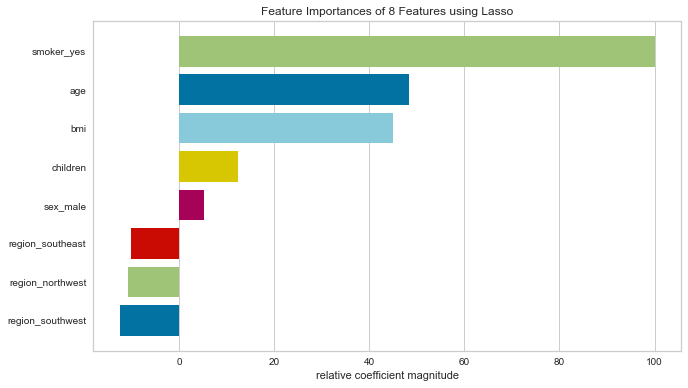

<AxesSubplot:title={'center':'Feature Importances of 8 Features using Lasso'}, xlabel='relative coefficient magnitude'>

In [60]:
from yellowbrick.model_selection import FeatureImportances
from yellowbrick.features import RadViz

viz = FeatureImportances(lasso_grid_model.best_estimator_.named_steps["lasso"])
visualizer = RadViz(size=(700, 400))
viz.fit(X_train, y_train)
viz.show()

***residuals***

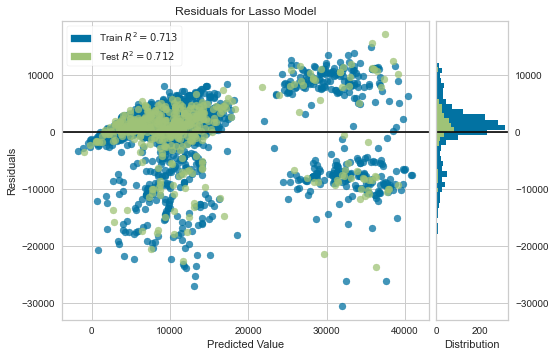

In [61]:
from yellowbrick.regressor import ResidualsPlot

operations = [("scaler", MinMaxScaler()), ("lasso", Lasso(alpha=0.55, random_state=101))]
model = Pipeline(steps=operations)
visualizer = ResidualsPlot(model)

visualizer.fit(X_train, y_train) 
visualizer.score(X_test, y_test)  
visualizer.show(); 

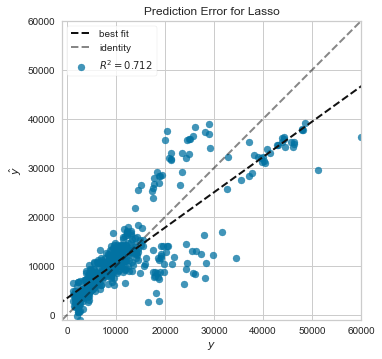

In [62]:
from yellowbrick.regressor import PredictionError
# visualizer = RadViz(size=(500, 500))
visualizer = PredictionError(model)

visualizer.fit(X_train, y_train) 
visualizer.score(X_test, y_test)  
visualizer.show();

<div class="alert alert-block alert-danger">
    
<b>Elastic_Net Regression</b>
    
</div>

In [63]:
operations_elasticnet = [("scaler", MinMaxScaler()), ("elasticnet", ElasticNet(random_state=101))]
pipe_elasticnet_model = Pipeline(steps=operations_elasticnet)
pipe_elasticnet_model.fit(X_train,y_train)

Pipeline(steps=[('scaler', MinMaxScaler()),
                ('elasticnet', ElasticNet(random_state=101))])

In [64]:
pipe_elasticnet_model.get_params()

{'memory': None,
 'steps': [('scaler', MinMaxScaler()),
  ('elasticnet', ElasticNet(random_state=101))],
 'verbose': False,
 'scaler': MinMaxScaler(),
 'elasticnet': ElasticNet(random_state=101),
 'scaler__clip': False,
 'scaler__copy': True,
 'scaler__feature_range': (0, 1),
 'elasticnet__alpha': 1.0,
 'elasticnet__copy_X': True,
 'elasticnet__fit_intercept': True,
 'elasticnet__l1_ratio': 0.5,
 'elasticnet__max_iter': 1000,
 'elasticnet__normalize': False,
 'elasticnet__positive': False,
 'elasticnet__precompute': False,
 'elasticnet__random_state': 101,
 'elasticnet__selection': 'cyclic',
 'elasticnet__tol': 0.0001,
 'elasticnet__warm_start': False}

In [65]:
train_val(pipe_elasticnet_model, X_train, y_train, X_test, y_test)

,train,test
R2,0.256,0.242
mae,6570.997,6391.637
mse,84810052.512,78929756.226
rmse,9209.237,8884.242


In [66]:
# CROSS VALIDATE

operations_elasticnet = [("scaler", MinMaxScaler()), ("elasticnet", ElasticNet(random_state=101))]
pipe_elasticnet_model = Pipeline(steps=operations_elasticnet)

scores = cross_validate(pipe_elasticnet_model, X_train, y_train, scoring=['r2','neg_mean_absolute_error',
                                                            'neg_mean_squared_error','neg_root_mean_squared_error'], cv=10)
scores = pd.DataFrame(scores, index=range(1,11))
scores.iloc[:, 2:].mean()

test_r2                                    0.249
test_neg_mean_absolute_error           -6581.511
test_neg_mean_squared_error        -85135641.489
test_neg_root_mean_squared_error       -9193.473
dtype: float64

***grid search***

In [67]:
# ELASTIC_NET GRID SEARCH

operations_elasticnet = [("scaler", MinMaxScaler()), ("elasticnet", ElasticNet(random_state=101))]
pipe_elasticnet_model = Pipeline(steps=operations_elasticnet)

param_grid = {'elasticnet__alpha':[0.01, 0.1, 0.2, 0.5, 0.6, 0.7, 1],
              'elasticnet__l1_ratio':[0.1, 0.3, 0.5, 0.7, 0.9]}

elastic_grid_model = GridSearchCV(estimator=pipe_elasticnet_model, param_grid=param_grid, verbose=1,
                                  scoring='neg_root_mean_squared_error', cv=10).fit(X_train, y_train)

print('\n', elastic_grid_model.best_params_)
print('\n', elastic_grid_model.best_score_)

Fitting 10 folds for each of 35 candidates, totalling 350 fits

 {'elasticnet__alpha': 0.01, 'elasticnet__l1_ratio': 0.9}

 -5746.842647536368


In [68]:
elasticnet_scores = train_val(elastic_grid_model, X_train, y_train, X_test, y_test)
elasticnet_scores

,train,test
R2,0.712,0.712
mae,3855.965,3640.440
mse,32800198.901,30023861.993
rmse,5727.146,5479.403


In [69]:
y_pred = elastic_grid_model.predict(X_test)
elasticnet_R2 = r2_score(y_test, y_pred)
elasticnet_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
elasticnet_cvscore = -elastic_grid_model.best_score_

***feature importance***

In [70]:
elastic_grid_model.best_estimator_.named_steps["elasticnet"]

ElasticNet(alpha=0.01, l1_ratio=0.9, random_state=101)

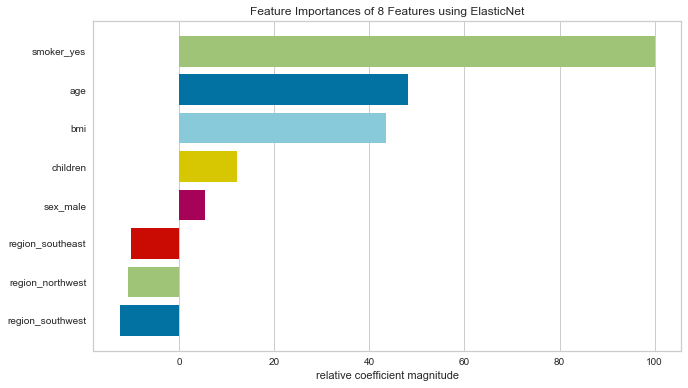

<AxesSubplot:title={'center':'Feature Importances of 8 Features using ElasticNet'}, xlabel='relative coefficient magnitude'>

In [71]:
from yellowbrick.model_selection import FeatureImportances
from yellowbrick.features import RadViz

viz = FeatureImportances(elastic_grid_model.best_estimator_.named_steps["elasticnet"])
visualizer = RadViz(size=(700, 400))
viz.fit(X_train, y_train)
viz.show()

***residuals***

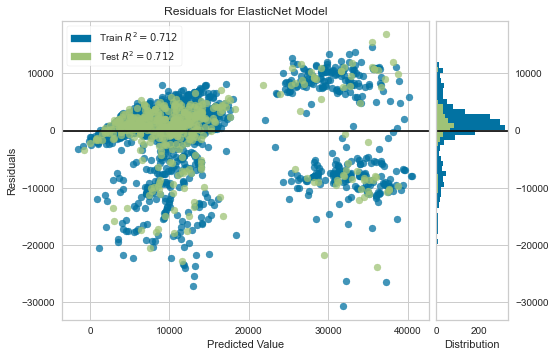

In [72]:
from yellowbrick.regressor import ResidualsPlot

operations = [("scaler", MinMaxScaler()), ("elasticnet", ElasticNet(alpha=0.01, l1_ratio=0.9, random_state=101))]
model = Pipeline(steps=operations)
visualizer = ResidualsPlot(model)

visualizer.fit(X_train, y_train) 
visualizer.score(X_test, y_test)  
visualizer.show(); 

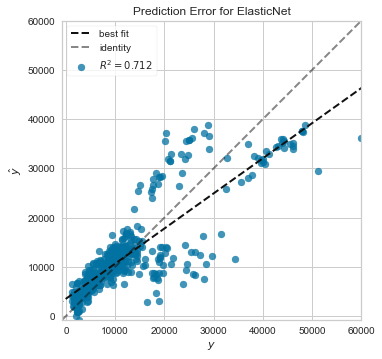

In [73]:
from yellowbrick.regressor import PredictionError
# visualizer = RadViz(size=(500, 500))
visualizer = PredictionError(model)

visualizer.fit(X_train, y_train) 
visualizer.score(X_test, y_test)  
visualizer.show();

<div class="alert alert-block alert-danger">
    
<b>KNN (K Nearest Neighbors)</b>
    
</div>

In [74]:
operations_knn = [("scaler", MinMaxScaler()), ("knn", KNeighborsRegressor())]
pipe_model_knn = Pipeline(steps=operations_knn)
pipe_model_knn.fit(X_train, y_train)

Pipeline(steps=[('scaler', MinMaxScaler()), ('knn', KNeighborsRegressor())])

In [75]:
pipe_model_knn.get_params()

{'memory': None,
 'steps': [('scaler', MinMaxScaler()), ('knn', KNeighborsRegressor())],
 'verbose': False,
 'scaler': MinMaxScaler(),
 'knn': KNeighborsRegressor(),
 'scaler__clip': False,
 'scaler__copy': True,
 'scaler__feature_range': (0, 1),
 'knn__algorithm': 'auto',
 'knn__leaf_size': 30,
 'knn__metric': 'minkowski',
 'knn__metric_params': None,
 'knn__n_jobs': None,
 'knn__n_neighbors': 5,
 'knn__p': 2,
 'knn__weights': 'uniform'}

In [76]:
train_val(pipe_model_knn, X_train, y_train, X_test, y_test)

,train,test
R2,0.877,0.818
mae,1816.297,2195.202
mse,14021719.610,18954006.014
rmse,3744.559,4353.620


In [77]:
# CROSS VALIDATE

operations_knn = [("scaler", MinMaxScaler()), ("knn", KNeighborsRegressor())]
pipe_model_knn = Pipeline(steps=operations_knn)

scores = cross_validate(pipe_model_knn, X_train, y_train, scoring=['r2','neg_mean_absolute_error',
                                                            'neg_mean_squared_error','neg_root_mean_squared_error'], cv=10)
scores = pd.DataFrame(scores, index=range(1,11))
scores.iloc[:, 2:].mean()

test_r2                                    0.805
test_neg_mean_absolute_error           -2363.456
test_neg_mean_squared_error        -22021560.287
test_neg_root_mean_squared_error       -4670.538
dtype: float64

***Elbow Method for Choosing Reasonable K Values***

In [78]:
test_error_rates = []

for k in range(1,30):
    
    operations_knn = [("scaler", MinMaxScaler()), ("knn", KNeighborsRegressor(n_neighbors=k))]
    pipe_model_knn = Pipeline(steps=operations_knn)
    pipe_model_knn.fit(X_train, y_train) 
   
    y_pred = pipe_model_knn.predict(X_test)
    
    test_error = np.sqrt(mean_squared_error(y_test, y_pred))
    test_error_rates.append(test_error)

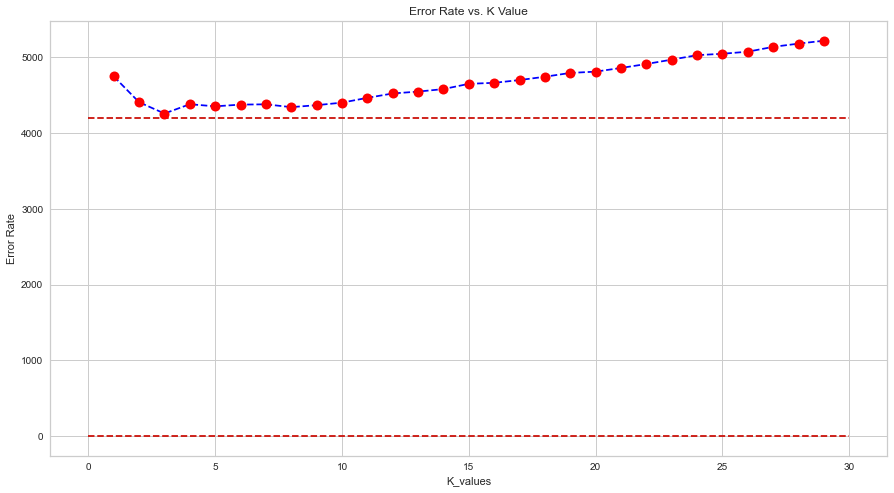

In [79]:
plt.figure(figsize=(15,8))
plt.plot(range(1,30), test_error_rates, color='blue', linestyle='--', marker='o', markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K_values')
plt.ylabel('Error Rate')
plt.hlines(y=4200, xmin = 0, xmax = 30, colors= 'r', linestyles="--")
plt.hlines(y=0, xmin = 0, xmax = 30, colors= 'r', linestyles="--")

In [80]:
operations_knn = [("scaler", MinMaxScaler()), ("knn", KNeighborsRegressor(n_neighbors=3))]
pipe_model_knn = Pipeline(steps=operations_knn)
pipe_model_knn.fit(X_train, y_train)

Pipeline(steps=[('scaler', MinMaxScaler()),
                ('knn', KNeighborsRegressor(n_neighbors=3))])

In [81]:
train_val(pipe_model_knn, X_train, y_train, X_test, y_test)

,train,test
R2,0.912,0.826
mae,1421.566,2114.738
mse,10025484.384,18137527.992
rmse,3166.305,4258.818


***grid search***

In [82]:
# GRID SEARCH

operations_knn = [("scaler", MinMaxScaler()), ("knn", KNeighborsRegressor(n_neighbors=3))]
pipe_model_knn = Pipeline(steps=operations_knn)

param_grid = {'knn__weights': ['uniform', 'distance'], 'knn__algorithm' : ['auto', 'ball_tree', 'kd_tree', 'brute'], 
              'knn__p': [1, 2]}

knn_grid_model = GridSearchCV(estimator=pipe_model_knn, param_grid=param_grid, verbose=1,
                                  scoring='neg_root_mean_squared_error', cv=10, n_jobs = -1).fit(X_train, y_train)

print('\n', knn_grid_model.best_params_)
print('\n', knn_grid_model.best_score_)

Fitting 10 folds for each of 16 candidates, totalling 160 fits

 {'knn__algorithm': 'auto', 'knn__p': 1, 'knn__weights': 'distance'}

 -4540.983170456355


In [83]:
KNN_scores = train_val(knn_grid_model, X_train, y_train, X_test, y_test)
KNN_scores

,train,test
R2,1.000,0.826
mae,0.000,1963.702
mse,0.000,18087229.004
rmse,0.000,4252.908


In [84]:
# GRID SEARCH-2
# as reducing overfitting, I will tune the hyperparameters and n_neighbors
# (after a few tries)

operations_knn = [("scaler", MinMaxScaler()), ("knn", KNeighborsRegressor())]
pipe_model_knn = Pipeline(steps=operations_knn)

param_grid = {'knn__n_neighbors': [3, 6, 8, 10], 'knn__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'], 
              'knn__leaf_size':[20, 30], 'knn__weights': ['uniform'], 'knn__p': [1, 2]}

knn_grid_model = GridSearchCV(estimator=pipe_model_knn, param_grid=param_grid, verbose=1,
                                  scoring='neg_root_mean_squared_error', cv=10, n_jobs = -1).fit(X_train, y_train)

print('\n', knn_grid_model.best_params_)
print('\n', knn_grid_model.best_score_)

Fitting 10 folds for each of 64 candidates, totalling 640 fits

 {'knn__algorithm': 'auto', 'knn__leaf_size': 20, 'knn__n_neighbors': 8, 'knn__p': 1, 'knn__weights': 'uniform'}

 -4588.891808435228


In [85]:
KNN_scores = train_val(knn_grid_model, X_train, y_train, X_test, y_test)
KNN_scores

,train,test
R2,0.857,0.814
mae,2057.773,2296.527
mse,16258062.884,19398836.916
rmse,4032.129,4404.411


In [86]:
y_pred = knn_grid_model.predict(X_test)
KNN_R2 = r2_score(y_test, y_pred)
KNN_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
KNN_cvscore = -knn_grid_model.best_score_

***residuals***

In [87]:
knn_grid_model.best_estimator_

Pipeline(steps=[('scaler', MinMaxScaler()),
                ('knn', KNeighborsRegressor(leaf_size=20, n_neighbors=8, p=1))])

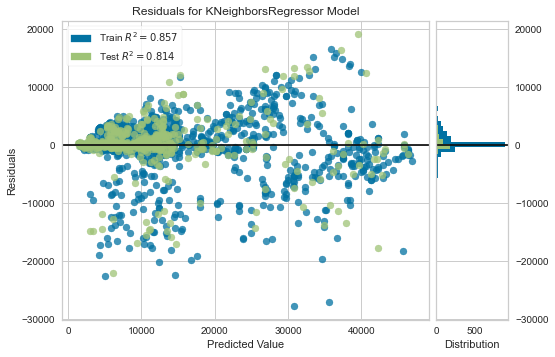

In [88]:
from yellowbrick.regressor import ResidualsPlot

operations = [("scaler", MinMaxScaler()), ("knn", KNeighborsRegressor(n_neighbors=8, leaf_size=20, p=1))]
model = Pipeline(steps=operations)
visualizer = ResidualsPlot(model)

visualizer.fit(X_train, y_train) 
visualizer.score(X_test, y_test)  
visualizer.show(); 

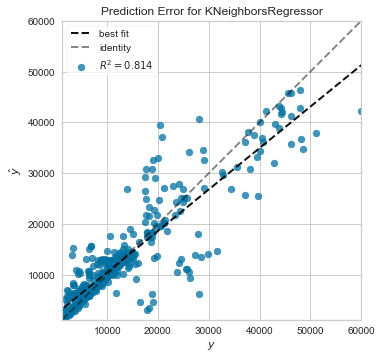

In [89]:
from yellowbrick.regressor import PredictionError
# visualizer = RadViz(size=(500, 500))
visualizer = PredictionError(model)

visualizer.fit(X_train, y_train) 
visualizer.score(X_test, y_test)  
visualizer.show();

<div class="alert alert-block alert-danger">
    
<b>SVR (Support Vector Regression)</b>
    
</div>

In [90]:
operations_svr = [("scaler", MinMaxScaler()), ("svr", SVR())]
pipe_model_svr = Pipeline(steps=operations_svr)
pipe_model_svr.fit(X_train,y_train)

Pipeline(steps=[('scaler', MinMaxScaler()), ('svr', SVR())])

In [91]:
pipe_model_svr.get_params()

{'memory': None,
 'steps': [('scaler', MinMaxScaler()), ('svr', SVR())],
 'verbose': False,
 'scaler': MinMaxScaler(),
 'svr': SVR(),
 'scaler__clip': False,
 'scaler__copy': True,
 'scaler__feature_range': (0, 1),
 'svr__C': 1.0,
 'svr__cache_size': 200,
 'svr__coef0': 0.0,
 'svr__degree': 3,
 'svr__epsilon': 0.1,
 'svr__gamma': 'scale',
 'svr__kernel': 'rbf',
 'svr__max_iter': -1,
 'svr__shrinking': True,
 'svr__tol': 0.001,
 'svr__verbose': False}

In [92]:
train_val(pipe_model_svr, X_train, y_train, X_test, y_test)

,train,test
R2,-0.092,-0.057
mae,6974.291,6578.465
mse,124511968.139,109994422.662
rmse,11158.493,10487.823


In [93]:
# CROSS VALIDATE

operations_svr = [("scaler", MinMaxScaler()), ("svr", SVR())]
pipe_model_svr = Pipeline(steps=operations_svr)

scores = cross_validate(pipe_model_svr, X_train, y_train, scoring=['r2','neg_mean_absolute_error',
                                                            'neg_mean_squared_error','neg_root_mean_squared_error'], cv=10)
scores = pd.DataFrame(scores, index=range(1,11))
scores.iloc[:, 2:].mean()

test_r2                                    -0.094
test_neg_mean_absolute_error            -6984.215
test_neg_mean_squared_error        -124653600.994
test_neg_root_mean_squared_error       -11110.016
dtype: float64

***Grid Search***

In [94]:
# GRID SEARCH

operations_svr = [("scaler", MinMaxScaler()), ("svr", SVR())]
pipe_model_svr = Pipeline(steps=operations_svr)

param_grid = [
        {'svr__kernel': ['linear'], 'svr__C': [0.01, 0.1, 1, 10, 100]},
        {'svr__kernel': ['rbf', 'sigmoid'], 'svr__C': [0.01, 0.1, 1, 10, 100], 'svr__gamma': ['auto', 'scale', 1]},
        {'svr__kernel': ['poly'], 'svr__degree':[3, 4, 5], 'svr__gamma':['auto', 'scale', 1], 'svr__C':[0.01, 0.1, 1, 10, 100]}
]
  
svr_grid_model = GridSearchCV(estimator=pipe_model_svr, param_grid=param_grid, verbose=1,
                                  scoring='neg_root_mean_squared_error', cv=10, n_jobs=-1).fit(X_train, y_train)

print('\n', svr_grid_model.best_params_)
print('\n', svr_grid_model.best_score_)

Fitting 10 folds for each of 80 candidates, totalling 800 fits

 {'svr__C': 100, 'svr__degree': 5, 'svr__gamma': 1, 'svr__kernel': 'poly'}

 -4928.444208590128


In [95]:
# I won't increase the poly kernel's degree any more
SVR_scores = train_val(svr_grid_model, X_train, y_train, X_test, y_test)
SVR_scores

,train,test
R2,0.799,0.796
mae,2268.538,2223.006
mse,22920501.499,21209105.465
rmse,4787.536,4605.334


In [96]:
svr_grid_model.best_estimator_

Pipeline(steps=[('scaler', MinMaxScaler()),
                ('svr', SVR(C=100, degree=5, gamma=1, kernel='poly'))])

In [97]:
# CROSS VALIDATE
# The rmse test score seems close to the GridSearch best_score (average of cv rmse scores), 
# but considering the overfitting issue I'll check the other scores with cross validation

operations_svr = [("scaler", MinMaxScaler()), ("svr", SVR(kernel='poly', gamma=1, degree=5, C=100))]
pipe_model_svr = Pipeline(steps=operations_svr)

scores = cross_validate(pipe_model_svr, X_train, y_train, scoring=['r2','neg_mean_absolute_error',
                                                            'neg_mean_squared_error','neg_root_mean_squared_error'], cv=10)
scores = pd.DataFrame(scores, index=range(1,11))
scores.iloc[:, 2:].mean()

test_r2                                    0.781
test_neg_mean_absolute_error           -2439.294
test_neg_mean_squared_error        -24612842.826
test_neg_root_mean_squared_error       -4928.444
dtype: float64

In [98]:
y_pred = svr_grid_model.predict(X_test)
SVR_R2 = r2_score(y_test, y_pred)
SVR_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
SVR_cvscore = -svr_grid_model.best_score_

***residuals***

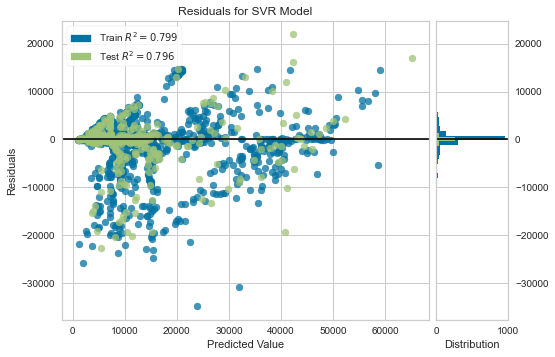

In [99]:
from yellowbrick.regressor import ResidualsPlot
operations = [("scaler", MinMaxScaler()), ("svr", SVR(kernel='poly', gamma=1, degree=5, C=100))]
model = Pipeline(steps=operations)
visualizer = ResidualsPlot(model)

visualizer.fit(X_train, y_train) 
visualizer.score(X_test, y_test)  
visualizer.show(); 

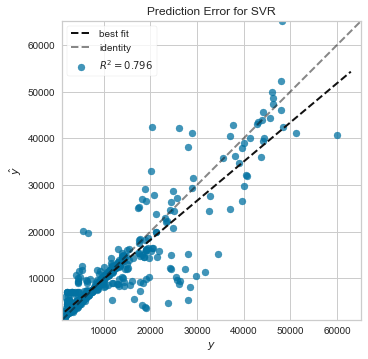

In [100]:
from yellowbrick.regressor import PredictionError
# visualizer = RadViz(size=(500, 500))
visualizer = PredictionError(model)

visualizer.fit(X_train, y_train) 
visualizer.score(X_test, y_test)  
visualizer.show();

<div class="alert alert-block alert-danger">
    
<b>Decision Tree</b>
    
</div>

***OrdinalEncoder***

In [101]:
X2 = df.drop('charges',axis=1)
y = df['charges']

cat = X2.select_dtypes("object").columns
cat

Index(['sex', 'smoker', 'region'], dtype='object')

In [102]:
enc = OrdinalEncoder()
X2[cat] = enc.fit_transform(X2[cat])
X2.head()

,age,sex,bmi,smoker,region,children
0,21,1.000,25.745,0.000,0.000,2
1,37,0.000,25.744,1.000,2.000,3
2,18,1.000,30.030,0.000,2.000,1
3,37,1.000,30.677,0.000,0.000,3
4,58,1.000,32.010,0.000,2.000,1


In [103]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y, test_size=0.2, random_state=42)

In [104]:
print("Train features shape : ", X_train2.shape)
print("Train target shape   : ", y_train2.shape)
print("Test features shape  : ", X_test2.shape)
print("Test target shape    : ", y_test2.shape)

Train features shape :  (2000, 6)
Train target shape   :  (2000,)
Test features shape  :  (500, 6)
Test target shape    :  (500,)


***Model Implementing***

In [105]:
DT_model = DecisionTreeRegressor(random_state=101)
DT_model.fit(X_train2, y_train2)

DecisionTreeRegressor(random_state=101)

In [106]:
DT_model.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 101,
 'splitter': 'best'}

In [107]:
train_val(DT_model, X_train2, y_train2, X_test2, y_test2)

,train,test
R2,1.000,0.762
mae,0.000,1872.552
mse,0.000,24778588.985
rmse,0.000,4977.810


In [108]:
# CROSS VALIDATE
# There is an overfitting problem

model = DecisionTreeRegressor(random_state=101)
scores = cross_validate(model, X_train2, y_train2, scoring=['r2', 
            'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_root_mean_squared_error'], cv=10)
df_scores = pd.DataFrame(scores)
df_scores.mean()[2:]

test_r2                                    0.770
test_neg_mean_absolute_error           -1958.208
test_neg_mean_squared_error        -25156118.440
test_neg_root_mean_squared_error       -4989.049
dtype: float64

***grid search***

In [109]:
# GRID SEARCH

model = DecisionTreeRegressor(random_state=101)

param_grid = {"splitter":["best", "random"],
              "max_depth": [None, 4, 5, 6, 7],
              "min_samples_leaf": [2, 3, 4, 5],
              "min_samples_split": [2, 3, 5],
              "max_features": [None, 2, 3]}

DT_grid_model = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_root_mean_squared_error', cv=10,
                                 verbose=1, n_jobs=-1).fit(X_train2, y_train2)

print('\n', DT_grid_model.best_params_)
print('\n', DT_grid_model.best_score_)

Fitting 10 folds for each of 360 candidates, totalling 3600 fits

 {'max_depth': 6, 'max_features': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'splitter': 'best'}

 -4017.1597094126837


In [110]:
train_val(DT_grid_model, X_train2, y_train2, X_test2, y_test2)

,train,test
R2,0.891,0.841
mae,1939.332,2192.878
mse,12376717.184,16599823.793
rmse,3518.056,4074.288


In [111]:
# GRID SEARCH-2
# as reducing overfitting, I will tune the hyperparameters
# (after a few tries)

model = DecisionTreeRegressor(random_state=101)

param_grid = {"splitter":["best", "random"],
              "max_depth": [5, 6],
              "min_samples_leaf": [3, 4],
              "min_samples_split": [2, 10],
              "max_features": [3, 4, 5]}

DT_grid_model = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_root_mean_squared_error', cv=10,
                                 verbose=1, n_jobs=-1).fit(X_train2, y_train2)

print('\n', DT_grid_model.best_params_)
print('\n', DT_grid_model.best_score_)

Fitting 10 folds for each of 48 candidates, totalling 480 fits

 {'max_depth': 6, 'max_features': 5, 'min_samples_leaf': 3, 'min_samples_split': 2, 'splitter': 'best'}

 -4009.7124991195915


In [112]:
DT_scores = train_val(DT_grid_model, X_train2, y_train2, X_test2, y_test2)
DT_scores

,train,test
R2,0.891,0.846
mae,1928.337,2058.624
mse,12450482.820,15995184.062
rmse,3528.524,3999.398


In [113]:
y_pred = DT_grid_model.predict(X_test2)
DT_R2 = r2_score(y_test2, y_pred)
DT_rmse = np.sqrt(mean_squared_error(y_test2, y_pred))
DT_cvscore = -DT_grid_model.best_score_

***feature importance***

In [114]:
DT_grid_model.best_estimator_

DecisionTreeRegressor(max_depth=6, max_features=5, min_samples_leaf=3,
                      random_state=101)

In [115]:
model = DecisionTreeRegressor(max_depth=6, max_features=5, min_samples_leaf=3, random_state=101)
model.fit(X_train2, y_train2)

df_f_i = pd.DataFrame(index=X2.columns, data = model.feature_importances_, 
                      columns = ["Feature Importance"]).sort_values("Feature Importance", ascending=False)
df_f_i

,Feature Importance
smoker,0.670
bmi,0.155
age,0.087
region,0.052
children,0.033
sex,0.004


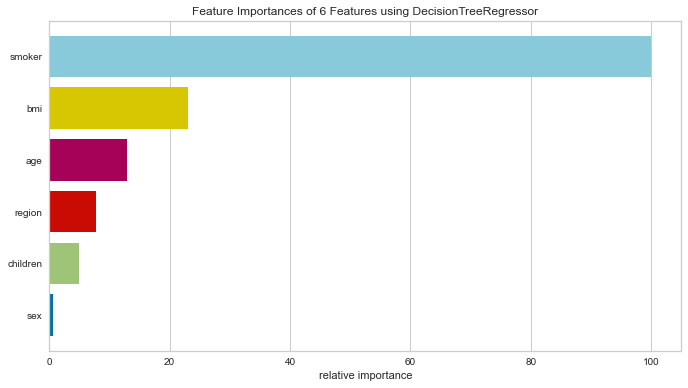

<AxesSubplot:title={'center':'Feature Importances of 6 Features using DecisionTreeRegressor'}, xlabel='relative importance'>

In [116]:
from yellowbrick.model_selection import FeatureImportances
from yellowbrick.features import RadViz

viz = FeatureImportances(DT_grid_model.best_estimator_)
visualizer = RadViz(size=(700, 400))
viz.fit(X_train2, y_train2)
viz.show()

***residuals***

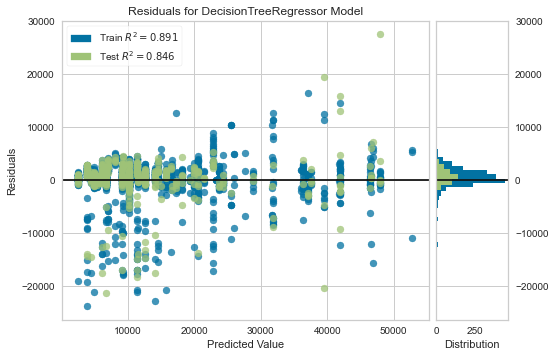

In [117]:
from yellowbrick.regressor import ResidualsPlot

visualizer = ResidualsPlot(model)

visualizer.fit(X_train2, y_train2) 
visualizer.score(X_test2, y_test2)  
visualizer.show(); 

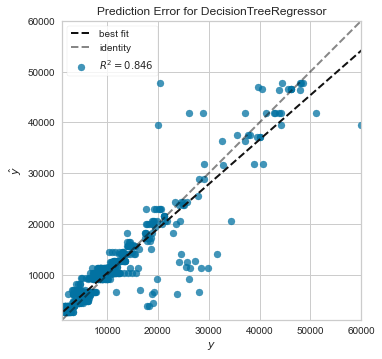

In [118]:
from yellowbrick.regressor import PredictionError
# visualizer = RadViz(size=(500, 500))
visualizer = PredictionError(model)

visualizer.fit(X_train2, y_train2) 
visualizer.score(X_test2, y_test2)  
visualizer.show();

<div class="alert alert-block alert-danger">
    
<b>Random Forest</b>
    
</div>

In [119]:
RF_model = RandomForestRegressor(random_state=101)
RF_model.fit(X_train2,y_train2)

RandomForestRegressor(random_state=101)

In [120]:
RF_model.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 101,
 'verbose': 0,
 'warm_start': False}

In [121]:
train_val(RF_model, X_train2, y_train2, X_test2, y_test2)

,train,test
R2,0.983,0.850
mae,639.941,1823.524
mse,1959139.027,15590989.243
rmse,1399.692,3948.543


In [122]:
# CROSS VALIDATE
# There is an overfitting problem

model = RandomForestRegressor(random_state=101)
scores = cross_validate(model, X_train2, y_train2, scoring=['r2', 
            'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_root_mean_squared_error'], cv=10)
df_scores = pd.DataFrame(scores)
df_scores.mean()[2:]

test_r2                                    0.869
test_neg_mean_absolute_error           -1732.115
test_neg_mean_squared_error        -14563701.536
test_neg_root_mean_squared_error       -3784.653
dtype: float64

***grid search***

In [123]:
# GRID SEARCH

model = RandomForestRegressor(random_state=101)

param_grid = {"n_estimators":[64, 100, 128],
              "max_depth": [None, 4, 5, 6],
              "min_samples_leaf": [1, 2, 3],
              "min_samples_split": [2, 3, 6],
              "max_features":['auto', 2, 3, 4]}

RF_grid_model = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_root_mean_squared_error', cv=10,
                             verbose=1, n_jobs = -1).fit(X_train2,y_train2)

print('\n', RF_grid_model.best_params_)
print('\n', RF_grid_model.best_score_)

Fitting 10 folds for each of 432 candidates, totalling 4320 fits

 {'max_depth': None, 'max_features': 4, 'min_samples_leaf': 1, 'min_samples_split': 6, 'n_estimators': 100}

 -3681.6272429339406


In [124]:
train_val(RF_grid_model, X_train2, y_train2, X_test2, y_test2)

,train,test
R2,0.960,0.856
mae,1005.831,1860.367
mse,4613809.186,15038199.600
rmse,2147.978,3877.912


In [125]:
# GRID SEARCH-2
# as reducing overfitting, I will tune the hyperparameters
# (after a few tries)

model = RandomForestRegressor(random_state=101)

param_grid = {"n_estimators":[50, 60],
              "max_depth": [5, 6],
              "min_samples_leaf": [4, 5],
              "min_samples_split": [9, 18],
              "max_features":[3, 4]}

RF_grid_model = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_root_mean_squared_error', cv=10,
                             verbose=1, n_jobs = -1).fit(X_train2,y_train2)

print('\n', RF_grid_model.best_params_)
print('\n', RF_grid_model.best_score_)

Fitting 10 folds for each of 32 candidates, totalling 320 fits

 {'max_depth': 6, 'max_features': 4, 'min_samples_leaf': 4, 'min_samples_split': 9, 'n_estimators': 60}

 -3850.8222919411915


In [126]:
RF_scores = train_val(RF_grid_model, X_train2, y_train2, X_test2, y_test2)
RF_scores

,train,test
R2,0.893,0.857
mae,1804.893,1977.607
mse,12257664.405,14870815.306
rmse,3501.095,3856.270


In [127]:
y_pred = RF_grid_model.predict(X_test2)
RF_R2 = r2_score(y_test2, y_pred)
RF_rmse = np.sqrt(mean_squared_error(y_test2, y_pred))
RF_cvscore = -RF_grid_model.best_score_

***feature importance***

In [128]:
RF_grid_model.best_estimator_

RandomForestRegressor(max_depth=6, max_features=4, min_samples_leaf=4,
                      min_samples_split=9, n_estimators=60, random_state=101)

In [129]:
model = RandomForestRegressor(max_depth=6, max_features=4, min_samples_leaf=4, min_samples_split=9, 
                              n_estimators=60, random_state=101)
model.fit(X_train2, y_train2)

df_f_i = pd.DataFrame(index=X2.columns, data = model.feature_importances_, 
                      columns = ["Feature Importance"]).sort_values("Feature Importance", ascending=False)
df_f_i

,Feature Importance
smoker,0.678
bmi,0.135
age,0.108
children,0.046
region,0.029
sex,0.004


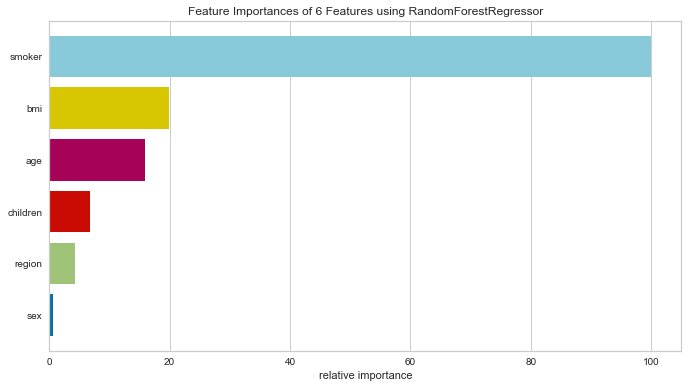

<AxesSubplot:title={'center':'Feature Importances of 6 Features using RandomForestRegressor'}, xlabel='relative importance'>

In [130]:
from yellowbrick.model_selection import FeatureImportances
from yellowbrick.features import RadViz

viz = FeatureImportances(RF_grid_model.best_estimator_)
visualizer = RadViz(size=(700, 400))
viz.fit(X_train2, y_train2)
viz.show()

***residuals***

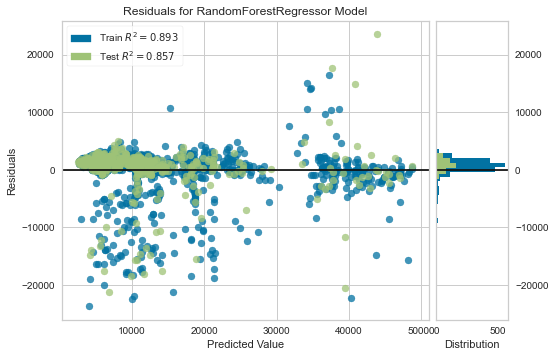

In [131]:
from yellowbrick.regressor import ResidualsPlot

visualizer = ResidualsPlot(model)

visualizer.fit(X_train2, y_train2) 
visualizer.score(X_test2, y_test2)  
visualizer.show(); 

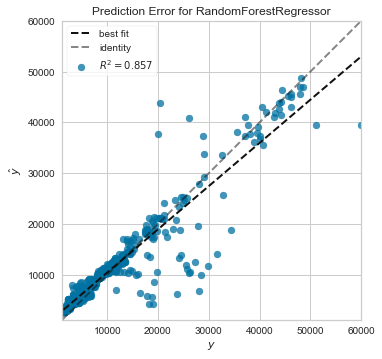

In [132]:
from yellowbrick.regressor import PredictionError
# visualizer = RadViz(size=(500, 500))
visualizer = PredictionError(model)

visualizer.fit(X_train2, y_train2) 
visualizer.score(X_test2, y_test2)  
visualizer.show();

<div class="alert alert-block alert-danger">
    
<b>AdaBoost (Adaptive Boosting)</b>
    
</div>

In [133]:
ADA_model = AdaBoostRegressor(random_state=101)
ADA_model.fit(X_train2, y_train2)

AdaBoostRegressor(random_state=101)

In [134]:
ADA_model.get_params()

{'base_estimator': None,
 'learning_rate': 1.0,
 'loss': 'linear',
 'n_estimators': 50,
 'random_state': 101}

In [135]:
train_val(ADA_model, X_train2, y_train2, X_test2, y_test2)

,train,test
R2,0.658,0.616
mae,5676.954,5729.975
mse,39037122.940,39970026.743
rmse,6247.970,6322.185


In [136]:
# CROSS VALIDATE

model = AdaBoostRegressor(random_state=101)
scores = cross_validate(model, X_train2, y_train2, scoring=['r2', 
            'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_root_mean_squared_error'], cv=10)
df_scores = pd.DataFrame(scores)
df_scores.mean()[2:]

test_r2                                    0.564
test_neg_mean_absolute_error           -6255.265
test_neg_mean_squared_error        -47932692.363
test_neg_root_mean_squared_error       -6897.851
dtype: float64

***grid search***

In [137]:
# GRID SEARCH
# (after a few tries)

model = AdaBoostRegressor(random_state=101)

param_grid = {"n_estimators": [50, 55, 64, 100],
              "learning_rate": [0.001, 0.005, 0.007, 0.01, 0.1],
              "loss": ["linear", "square"]}

ADA_grid_model = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_root_mean_squared_error', cv=10,
                             verbose=1, n_jobs = -1).fit(X_train2,y_train2)

print('\n', ADA_grid_model.best_params_)
print('\n', ADA_grid_model.best_score_)

Fitting 10 folds for each of 40 candidates, totalling 400 fits

 {'learning_rate': 0.01, 'loss': 'linear', 'n_estimators': 55}

 -4939.623747641471


In [138]:
ADA_scores = train_val(ADA_grid_model, X_train2, y_train2, X_test2, y_test2)
ADA_scores

,train,test
R2,0.800,0.774
mae,3010.462,3056.706
mse,22812179.751,23524948.811
rmse,4776.210,4850.252


In [139]:
y_pred = ADA_grid_model.predict(X_test2)
ADA_R2 = r2_score(y_test2, y_pred)
ADA_rmse = np.sqrt(mean_squared_error(y_test2, y_pred))
ADA_cvscore = -ADA_grid_model.best_score_

***feature importance***

In [140]:
ADA_grid_model.best_estimator_

AdaBoostRegressor(learning_rate=0.01, n_estimators=55, random_state=101)

In [141]:
model = AdaBoostRegressor(n_estimators=55, learning_rate=0.01, random_state=101)
model.fit(X_train2, y_train2)

df_f_i = pd.DataFrame(index=X2.columns, data = model.feature_importances_, 
                      columns = ["Feature Importance"]).sort_values("Feature Importance", ascending=False)
df_f_i

,Feature Importance
smoker,0.751
bmi,0.150
age,0.079
region,0.019
sex,0.000
children,0.000


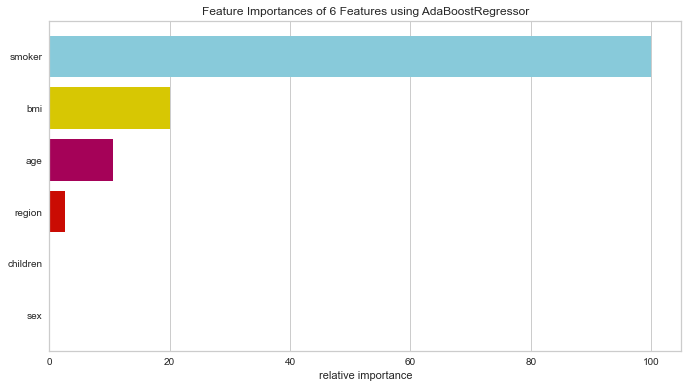

<AxesSubplot:title={'center':'Feature Importances of 6 Features using AdaBoostRegressor'}, xlabel='relative importance'>

In [142]:
from yellowbrick.model_selection import FeatureImportances
from yellowbrick.features import RadViz

viz = FeatureImportances(ADA_grid_model.best_estimator_)
visualizer = RadViz(size=(700, 400))
viz.fit(X_train2, y_train2)
viz.show()

***residuals***

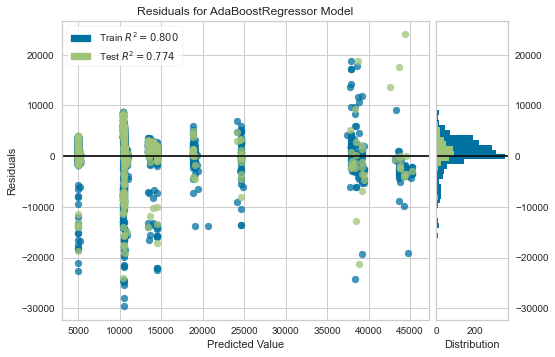

In [143]:
from yellowbrick.regressor import ResidualsPlot

visualizer = ResidualsPlot(model)

visualizer.fit(X_train2, y_train2) 
visualizer.score(X_test2, y_test2)  
visualizer.show(); 

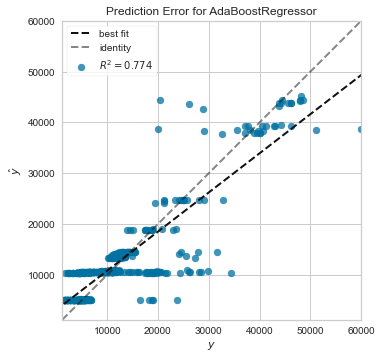

In [144]:
from yellowbrick.regressor import PredictionError
# visualizer = RadViz(size=(500, 500))
visualizer = PredictionError(model)

visualizer.fit(X_train2, y_train2) 
visualizer.score(X_test2, y_test2)  
visualizer.show();

<div class="alert alert-block alert-danger">
    
<b>Gradient Boosting Machine (GBM)</b>
    
</div>

In [145]:
gbm_model = GradientBoostingRegressor(random_state=101)
gbm_model.fit(X_train2, y_train2)

GradientBoostingRegressor(random_state=101)

In [146]:
gbm_model.get_params()

{'alpha': 0.9,
 'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'ls',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'random_state': 101,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [147]:
train_val(gbm_model, X_train2, y_train2, X_test2, y_test2)

,train,test
R2,0.886,0.839
mae,1958.978,2261.457
mse,13002566.662,16776352.511
rmse,3605.907,4095.895


In [148]:
# CROSS VALIDATE

model = GradientBoostingRegressor(random_state=101)
scores = cross_validate(model, X_train2, y_train2, scoring=['r2', 
            'neg_mean_absolute_error','neg_mean_squared_error','neg_root_mean_squared_error'], cv=10)
pd.DataFrame(scores)
pd.DataFrame(scores).mean()[2:]

test_r2                                    0.855
test_neg_mean_absolute_error           -2163.190
test_neg_mean_squared_error        -16235103.989
test_neg_root_mean_squared_error       -3998.876
dtype: float64

***grid search***

In [149]:
# GRID SEARCH

model = GradientBoostingRegressor(random_state=101)

param_grid = {"n_estimators":[100, 128, 200], "subsample":[0.5, 0.8, 1], "max_features" : [None, 3, 4],
              "learning_rate": [0.01, 0.1, 0.5], 'max_depth':[3, 4, 5], 'min_samples_split': [2, 10]}

gbm_grid_model = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_root_mean_squared_error', cv=10,
                              verbose=2, n_jobs = -1).fit(X_train2, y_train2)

print('\n', gbm_grid_model.best_params_)
print('\n', gbm_grid_model.best_score_)

Fitting 10 folds for each of 486 candidates, totalling 4860 fits

 {'learning_rate': 0.1, 'max_depth': 5, 'max_features': 4, 'min_samples_split': 2, 'n_estimators': 100, 'subsample': 1}

 -3821.185801537619


In [150]:
train_val(gbm_grid_model, X_train2, y_train2, X_test2, y_test2)

,train,test
R2,0.947,0.855
mae,1270.261,1990.505
mse,6092615.034,15059315.977
rmse,2468.322,3880.633


In [151]:
# GRID SEARCH-2
# as reducing overfitting, I will tune the hyperparameters
# (after a few tries)

model = GradientBoostingRegressor(random_state=101)

param_grid = {"n_estimators":[55, 64], "subsample":[0.5, 0.8, 1], "max_features" : [4, 5], 'min_samples_leaf':[2, 3],
              "learning_rate": [0.05, 0.06, 0.075], 'max_depth':[3, 4], 'min_samples_split': [10, 14]}

gbm_grid_model = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_root_mean_squared_error', cv=10,
                              verbose=2, n_jobs = -1).fit(X_train2, y_train2)

print('\n', gbm_grid_model.best_params_)
print('\n', gbm_grid_model.best_score_)

Fitting 10 folds for each of 288 candidates, totalling 2880 fits

 {'learning_rate': 0.075, 'max_depth': 4, 'max_features': 4, 'min_samples_leaf': 3, 'min_samples_split': 14, 'n_estimators': 64, 'subsample': 0.8}

 -3903.4518156389045


In [152]:
GBM_scores = train_val(gbm_grid_model, X_train2, y_train2, X_test2, y_test2)
GBM_scores

,train,test
R2,0.890,0.854
mae,1886.781,2046.410
mse,12565423.205,15156420.380
rmse,3544.774,3893.125


In [153]:
y_pred = gbm_grid_model.predict(X_test2)
GBM_R2 = r2_score(y_test2, y_pred)
GBM_rmse = np.sqrt(mean_squared_error(y_test2, y_pred))
GBM_cvscore = -gbm_grid_model.best_score_

***feature importance***

In [154]:
gbm_grid_model.best_estimator_

GradientBoostingRegressor(learning_rate=0.075, max_depth=4, max_features=4,
                          min_samples_leaf=3, min_samples_split=14,
                          n_estimators=64, random_state=101, subsample=0.8)

In [155]:
model = GradientBoostingRegressor(learning_rate=0.075, max_depth=4, max_features=4, min_samples_leaf=3, min_samples_split=14,
                                  n_estimators=64, random_state=101, subsample=0.8)
model.fit(X_train2, y_train2)

df_f_i = pd.DataFrame(index=X2.columns, data = model.feature_importances_, 
                      columns = ["Feature Importance"]).sort_values("Feature Importance", ascending=False)
df_f_i

,Feature Importance
smoker,0.666
bmi,0.138
age,0.111
children,0.050
region,0.034
sex,0.002


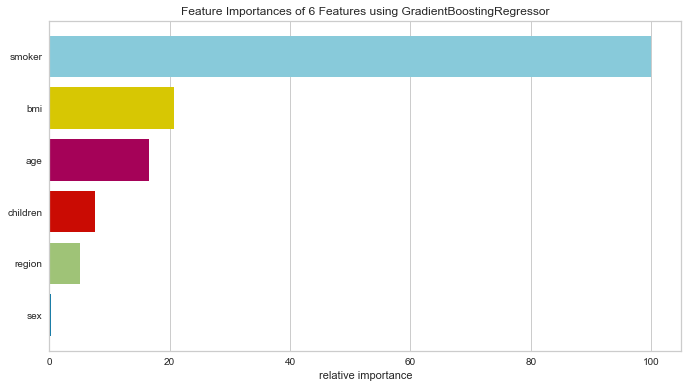

<AxesSubplot:title={'center':'Feature Importances of 6 Features using GradientBoostingRegressor'}, xlabel='relative importance'>

In [156]:
from yellowbrick.model_selection import FeatureImportances
from yellowbrick.features import RadViz

viz = FeatureImportances(gbm_grid_model.best_estimator_)
visualizer = RadViz(size=(700, 400))
viz.fit(X_train2, y_train2)
viz.show()

***residuals***

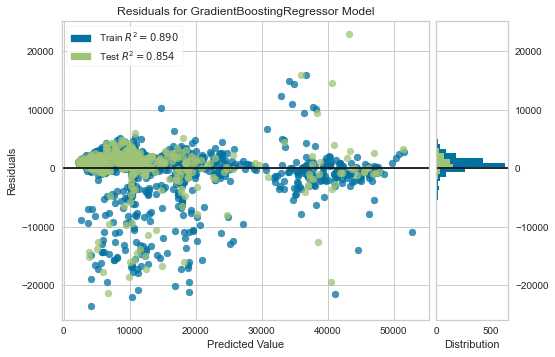

In [157]:
from yellowbrick.regressor import ResidualsPlot

visualizer = ResidualsPlot(model)

visualizer.fit(X_train2, y_train2) 
visualizer.score(X_test2, y_test2)  
visualizer.show();

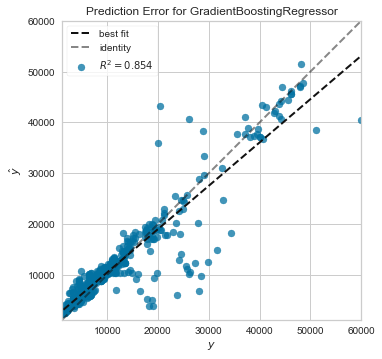

In [158]:
from yellowbrick.regressor import PredictionError
# visualizer = RadViz(size=(500, 500))
visualizer = PredictionError(model)

visualizer.fit(X_train2, y_train2) 
visualizer.score(X_test2, y_test2)  
visualizer.show();

<div class="alert alert-block alert-danger">
    
<b>Extreme Gradient Boosting (XGBoost)</b>
    
</div>

In [159]:
xgb_model = XGBRegressor(random_state=101)
xgb_model.fit(X_train2, y_train2)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=101,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [ ]:
#xgb_model.get_params()

In [160]:
train_val(xgb_model, X_train2, y_train2, X_test2, y_test2)

,train,test
R2,0.993,0.820
mae,509.574,2208.293
mse,754930.587,18756037.004
rmse,868.867,4330.824


In [161]:
# CROSS VALIDATE

model = XGBRegressor(random_state=101)
scores = cross_validate(model, X_train2, y_train2, scoring=['r2', 
            'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_root_mean_squared_error'], cv=10)
pd.DataFrame(scores)
pd.DataFrame(scores).mean()[2:]

test_r2                                    0.851
test_neg_mean_absolute_error           -2092.195
test_neg_mean_squared_error        -16575838.945
test_neg_root_mean_squared_error       -4052.857
dtype: float64

***grid search***

In [162]:
# GRID SEARCH

model = XGBRegressor(random_state=101)

param_grid = {"n_estimators":[64, 100, 128], "subsample":[0.5, 0.8, 1], "max_features" : [None, 3, 4],
              "learning_rate": [0.01, 0.1, 0.3], 'max_depth':[3, 4, 5], "colsample_bytree":[0.5, 1]}

xgboost_grid_model = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_root_mean_squared_error', cv=10,
                              verbose=2, n_jobs = -1).fit(X_train2, y_train2)
xgboost_grid_model.best_params_

Fitting 10 folds for each of 486 candidates, totalling 4860 fits


{'colsample_bytree': 1,
 'learning_rate': 0.1,
 'max_depth': 5,
 'max_features': None,
 'n_estimators': 64,
 'subsample': 0.8}

In [163]:
train_val(xgboost_grid_model, X_train2, y_train2, X_test2, y_test2)

,train,test
R2,0.927,0.858
mae,1459.355,1944.731
mse,8312346.366,14743652.513
rmse,2883.114,3839.746


In [164]:
# GRID SEARCH-2
# as reducing overfitting, I will tune the hyperparameters
# (after a few tries)

model = XGBRegressor(random_state=101)

param_grid = {"n_estimators":[50, 64, 80], 'subsample':[0.8], 'max_features': [None],
              "learning_rate": [0.03, 0.045, 0.05], 'max_depth':[3, 4], "colsample_bytree":[1]}

xgboost_grid_model = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_root_mean_squared_error', cv=10,
                              verbose=2, n_jobs = -1).fit(X_train2, y_train2)
xgboost_grid_model.best_params_

print('\n', xgboost_grid_model.best_params_)
print('\n', xgboost_grid_model.best_score_)

Fitting 10 folds for each of 18 candidates, totalling 180 fits

 {'colsample_bytree': 1, 'learning_rate': 0.05, 'max_depth': 4, 'max_features': None, 'n_estimators': 80, 'subsample': 0.8}

 -3963.262213163379


In [165]:
XGB_scores = train_val(xgboost_grid_model, X_train2, y_train2, X_test2, y_test2)
XGB_scores

,train,test
R2,0.883,0.855
mae,1875.352,1987.226
mse,13341658.596,15065218.447
rmse,3652.624,3881.394


In [166]:
y_pred = xgboost_grid_model.predict(X_test2)
XGB_R2 = r2_score(y_test2, y_pred)
XGB_rmse = np.sqrt(mean_squared_error(y_test2, y_pred))
XGB_cvscore = -xgboost_grid_model.best_score_

***feature importance***

In [167]:
xgboost_grid_model.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.05, max_delta_step=0,
             max_depth=4, max_features=None, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=80, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=101,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.8,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [168]:
model = XGBRegressor(n_estimators=80, subsample=0.8, learning_rate=0.05, max_depth=4, 
                                  max_features=None, colsample_bytree=1, random_state=101)
model.fit(X_train2, y_train2)

df_f_i = pd.DataFrame(index=X2.columns, data = model.feature_importances_, 
                      columns = ["Feature Importance"]).sort_values("Feature Importance", ascending=False)
df_f_i

,Feature Importance
smoker,0.877
bmi,0.043
region,0.027
children,0.025
age,0.023
sex,0.004


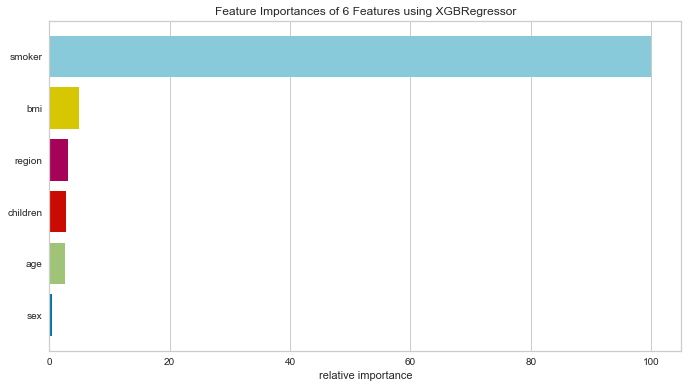

<AxesSubplot:title={'center':'Feature Importances of 6 Features using XGBRegressor'}, xlabel='relative importance'>

In [169]:
from yellowbrick.model_selection import FeatureImportances
from yellowbrick.features import RadViz

viz = FeatureImportances(xgboost_grid_model.best_estimator_)
visualizer = RadViz(size=(700, 400))
viz.fit(X_train2, y_train2)
viz.show()

***residuals***

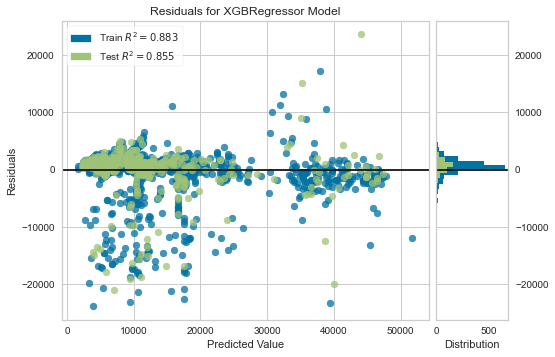

In [170]:
from yellowbrick.regressor import ResidualsPlot

visualizer = ResidualsPlot(model)

visualizer.fit(X_train2, y_train2) 
visualizer.score(X_test2, y_test2)  
visualizer.show();

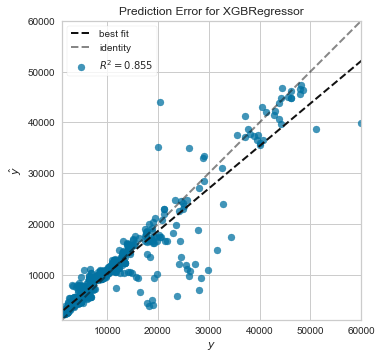

In [171]:
from yellowbrick.regressor import PredictionError
# visualizer = RadViz(size=(500, 500))
visualizer = PredictionError(model)

visualizer.fit(X_train2, y_train2) 
visualizer.score(X_test2, y_test2)  
visualizer.show();

***

# MODEL COMPARING

In [174]:
compare = pd.DataFrame({"Model": ["Linear Regression", "Ridge",  "Lasso", "Elastic_Net", "KNN", "SVR", "Decision Tree", 
                                  "Random Forest", "AdaBoost", "Gradient Boosting", "XGBoost"],
                    "R2": [linear_R2, ridge_R2, lasso_R2, elasticnet_R2, KNN_R2, SVR_R2, DT_R2, RF_R2, ADA_R2, GBM_R2, XGB_R2],
                    "rmse": [linear_rmse, ridge_rmse, lasso_rmse, elasticnet_rmse, KNN_rmse, SVR_rmse, DT_rmse, RF_rmse, 
                             ADA_rmse, GBM_rmse, XGB_rmse],
                    "cv_score": [linear_cvscore, ridge_cvscore, lasso_cvscore, elasticnet_cvscore, KNN_cvscore, 
                                 SVR_cvscore, DT_cvscore, RF_cvscore, ADA_cvscore, GBM_cvscore, XGB_cvscore]})

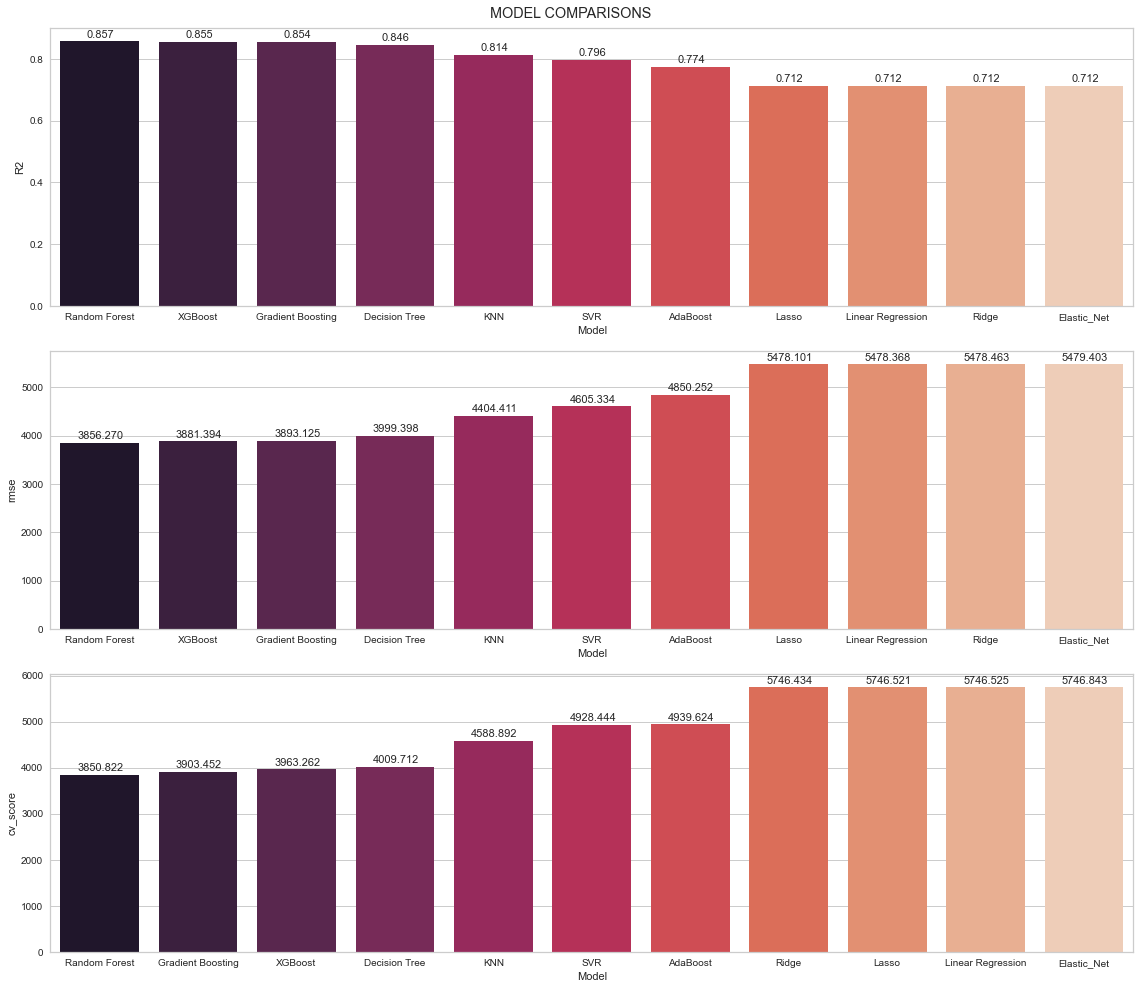

In [177]:
fig, ax = plt.subplots(3,1, figsize=(16,14))

def labels(ax, i):
    for p in ax[i].patches:
        ax[i].annotate(format(p.get_height(), '.3f'), (p.get_x() + p.get_width() / 2., p.get_height()),
                       ha='center', va='center', xytext=(1,7), textcoords='offset points', fontsize=11)
                
sns.barplot(x='Model', y='R2', data=compare.sort_values('R2', ascending=False), palette='rocket', ax = ax[0]), labels(ax,0)
sns.barplot(x='Model', y='rmse', data=compare.sort_values('rmse', ascending=True), palette='rocket', ax = ax[1]), labels(ax,1)
sns.barplot(x='Model', y='cv_score', data=compare.sort_values('cv_score', ascending=True), palette='rocket', ax = ax[2]), 
labels(ax,2)

fig.suptitle('MODEL COMPARISONS')
fig.tight_layout(); 

In [179]:
pd.concat([RF_scores, XGB_scores, DT_scores, GBM_scores], axis=1)

,train,test,train,test,train,test,train,test
R2,0.893,0.857,0.883,0.855,0.891,0.846,0.890,0.854
mae,1804.893,1977.607,1875.352,1987.226,1928.337,2058.624,1886.781,2046.410
mse,12257664.405,14870815.306,13341658.596,15065218.447,12450482.820,15995184.062,12565423.205,15156420.380
rmse,3501.095,3856.270,3652.624,3881.394,3528.524,3999.398,3544.774,3893.125


In [ ]:
# I will complete my model with the XGBoost algorithm because of less overfitting

***

# FINAL MODEL

In [180]:
final_model = XGBRegressor(n_estimators=80, subsample=0.8, learning_rate=0.05, max_depth=4, max_features=None, 
                           colsample_bytree=1, random_state=101).fit(X2, y)

In [181]:
# I will save my model using a pickle dump
import pickle
pickle.dump(final_model, open("XGBoost_final", 'wb'))

In [182]:
test_data = pd.read_csv("health_test.csv")
test_data.head()

,age,sex,bmi,smoker,region,children
0,39.297,male,29.978,no,northwest,4
1,40.368,female,27.928,no,southeast,5
2,32.882,male,41.577,no,southwest,5
3,62.000,female,30.495,no,northwest,2
4,32.476,male,30.323,yes,northeast,4


In [183]:
test_data.shape

(451, 6)

In [184]:
test_data.isnull().sum().sum()

0

***feature engineering***

In [185]:
test_data['age'] = test_data['age'].round().astype(int)

In [186]:
cat = test_data.select_dtypes("object").columns
cat

Index(['sex', 'smoker', 'region'], dtype='object')

In [187]:
enc = OrdinalEncoder()
test_data[cat] = enc.fit_transform(test_data[cat])
test_data.head()

,age,sex,bmi,smoker,region,children
0,39,1.000,29.978,0.000,1.000,4
1,40,0.000,27.928,0.000,2.000,5
2,33,1.000,41.577,0.000,3.000,5
3,62,0.000,30.495,0.000,1.000,2
4,32,1.000,30.323,1.000,0.000,4


***predict***

In [188]:
predictions = final_model.predict(test_data)
predictions[:50]

array([ 9616.102 ,  9279.326 ,  5869.077 , 15686.468 , 34808.42  ,
       11184.867 ,  9637.717 ,  9202.55  ,  9590.447 ,  2055.5698,
       10372.581 ,  3990.2834, 12555.266 ,  8874.726 , 10749.834 ,
       11357.768 ,  9044.843 ,  4609.8345,  3536.5186, 37580.875 ,
        5183.7266, 12089.032 , 24589.713 , 34042.17  ,  9040.854 ,
        6050.484 , 12024.927 ,  3559.4119,  4361.7754, 23837.691 ,
        5275.3916,  5395.6133,  4827.352 , 10477.164 , 37592.67  ,
        5578.92  , 18816.07  ,  9489.262 , 10477.164 , 46822.613 ,
       15574.292 , 12330.061 , 18388.94  , 38868.277 ,  5812.5933,
        8042.6714, 10324.535 , 11163.26  , 15290.141 , 14507.531 ],
      dtype=float32)

In [189]:
len(predictions)

451

In [190]:
predictions[predictions < 0]

array([], dtype=float32)

In [191]:
# with pickle
XGBoost_model = pickle.load(open("XGBoost_final", "rb"))

predictions2 = XGBoost_model.predict(test_data)
predictions2[:50]

array([ 9616.102 ,  9279.326 ,  5869.077 , 15686.468 , 34808.42  ,
       11184.867 ,  9637.717 ,  9202.55  ,  9590.447 ,  2055.5698,
       10372.581 ,  3990.2834, 12555.266 ,  8874.726 , 10749.834 ,
       11357.768 ,  9044.843 ,  4609.8345,  3536.5186, 37580.875 ,
        5183.7266, 12089.032 , 24589.713 , 34042.17  ,  9040.854 ,
        6050.484 , 12024.927 ,  3559.4119,  4361.7754, 23837.691 ,
        5275.3916,  5395.6133,  4827.352 , 10477.164 , 37592.67  ,
        5578.92  , 18816.07  ,  9489.262 , 10477.164 , 46822.613 ,
       15574.292 , 12330.061 , 18388.94  , 38868.277 ,  5812.5933,
        8042.6714, 10324.535 , 11163.26  , 15290.141 , 14507.531 ],
      dtype=float32)

In [192]:
submission = pd.DataFrame(predictions, columns=['Predictions'])
submission

,Predictions
0,9616.102
1,9279.326
2,5869.077
3,15686.468
4,34808.422
...,...
446,40783.648
447,17266.889
448,11408.849
449,11224.860


In [193]:
submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 451 entries, 0 to 450
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Predictions  451 non-null    float32
dtypes: float32(1)
memory usage: 1.9 KB


In [ ]:
# submission.to_csv('charges_predictions.csv', index=False)